# sentiment-analysis

In [3]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [4]:
# Importing required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None) # display more texts in column
pd.set_option('display.max_rows', 500)


from wordcloud import WordCloud
import re
import emot

from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS


#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')

from pywsd.utils import lemmatize_sentence
from nltk.stem import WordNetLemmatizer 
from gensim.models import Word2Vec


from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

Warming up PyWSD (takes ~10 secs)... took 6.2555694580078125 secs.


In [5]:
df = pd.read_csv('/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv', sep='\t')

# Data Exploration

In [6]:
df.rating.value_counts()

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64

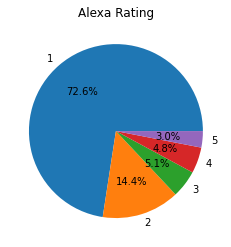

In [7]:
labels = ['1','2','3','4','5']
plt.pie(df.rating.value_counts(), labels=labels, autopct='%1.1f%%')
plt.title('Alexa Rating')
plt.show()

In [8]:
print ('Shape of dataframe:', df.shape)

Shape of dataframe: (3150, 5)


In [9]:
df[df['rating']==1][-3:]

,rating,date,variation,verified_reviews,feedback
3048,1,30-Jul-18,White Dot,NOT CONNECTED TO MY PHONE PLAYLIST :(,0
3091,1,30-Jul-18,Black Dot,I didn’t order it,0
3096,1,30-Jul-18,White Dot,The product sounded the same as the emoji speaker from five below my sister has ... and even that one has Bluetooth and doesn’t need to be plugged in. The only good thing about this is that you can speak to it.,0


In [10]:
df[df['rating']==3][27:30]

,rating,date,variation,verified_reviews,feedback
611,3,3-Jun-18,Black,"I received an Echo as a gift, loved it so much I decided to get the Dot for my bedroom. Both very easy to set up but a big difference in the sound quality. I would still buy it again.",1
644,3,27-May-18,Black,"It works great, but the reason I'm leaving 3 stars is because it wont play unless it plugged in the whole time. Pretty irritating especially when there is no outlet available.",1
681,3,19-May-18,Black,Seems to have trouble hearing me when I say the wake word despite being trained to my voice... Wonder if this has something to do with buying it refurbished. Our google home mini has no problems hearing us 😬 and is much louder.,1


In [11]:
df[df['rating']==5][-3:]

,rating,date,variation,verified_reviews,feedback
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, checking time, looking up weather. There are many more task to learn. It was simple to set up.",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my entire home, TV, all my lights, my thermostat, my front door dead bolt, the cameras... and i love listening to npr. these things are well worth the value and they really shine once you stat adding smart devices and you can control your entire home like its right out of star trek.... I named mine computer to get the feel... but its amazing what you can do with these devices and smart systems.",1
3148,5,30-Jul-18,White Dot,"Only complaint I have is that the sound quality isn't great. I mostly use it for commands though, and I have another dot hooked up to my stereo system to play music through. I have a couple friends that have a dot and don't mind the audio quality, but if you're bothered by that kind of thing I'd go with the full size echo or make sure you hook the do up to some larger speakers.",1


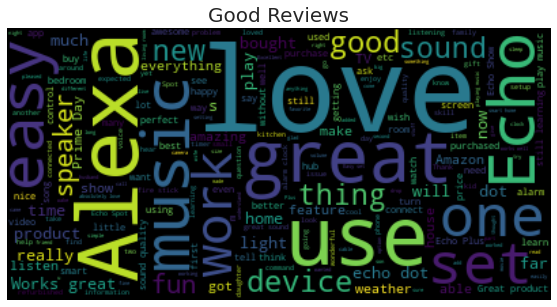

In [12]:
np.random.seed(88)
sns.set(rc={'figure.figsize':(10,5)})
reviews = ' '.join(df[df['rating']==5]['verified_reviews'].tolist())

wordcloud = WordCloud(background_color="black").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Good Reviews',size=20)
plt.show()

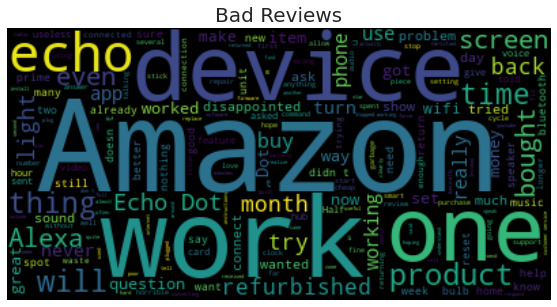

In [13]:
np.random.seed(88)
sns.set(rc={'figure.figsize':(10,5)})
reviews = ' '.join(df[df['rating']==1]['verified_reviews'].tolist())

wordcloud = WordCloud(background_color="black").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Bad Reviews',size=20)
plt.show()

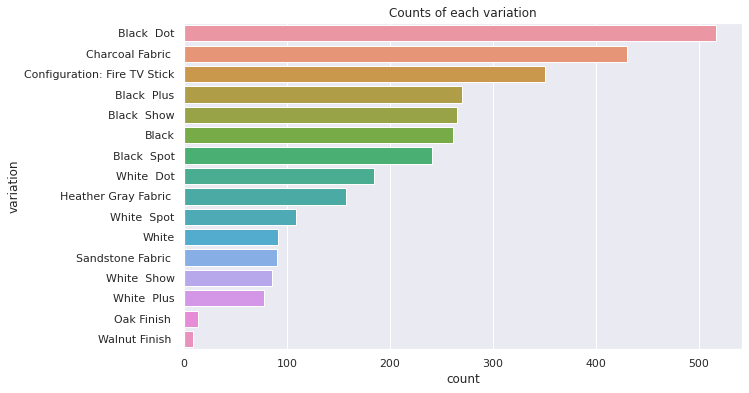

In [14]:
sns.set(rc={'figure.figsize':(10,6)})
sns.countplot(data = df, y='variation',
              order = df['variation'].value_counts().index)
plt.title('Counts of each variation')
plt.show()

# Data Cleaning

In [15]:
print('Number of rows without review =', len(df[df['verified_reviews']==' ']))
print('Number of duplicated rows =', len(df[df.duplicated()]))

# remove rows without reviews
df = df[df['verified_reviews']!=' ']

# remove duplicated rows
df = df.drop_duplicates()

print ('Dataframe shape after removing rows without reviews and removing duplicated rows :', df.shape)

Number of rows without review = 79
Number of duplicated rows = 715
Dataframe shape after removing rows without reviews and removing duplicated rows : (2385, 5)


### Emoji and Emoticons
- There are a few emojis and emoticons used in reviews
- Below are some attempts to find them, and replace with words

In [16]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

# Get a list of reviews that contain emojis
reviews_with_emoji = []
for t in df['verified_reviews']:
    a = re.findall(emoji_pattern,t)
    if a!=[]:
        reviews_with_emoji.append(t)

# Get a list of reviews that contain emoticons
reviews_with_emoticon = []
for t in df['verified_reviews']:
    for i in EMOTICONS_EMO:
        if i in t:
            reviews_with_emoticon.append(t)

In [17]:
# Function for converting emojis into word
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, ' '+"_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split())+' ')
    return text

# Function for converting emoticons into word
def convert_emoticons(text):
    for i,v in EMOTICONS_EMO.items():
        if i in text:
            text = text.replace(i,"_".join(v.replace(",","").split()))
            break
    return text


#### The conversion of emojis to words is pretty good!! 😁

In [18]:
for n in [1,2,3]:
    print('Original:\n',reviews_with_emoji[n],'\n')
    print('Converted:\n', convert_emojis(reviews_with_emoji[n]),'\n')

Original:
 😍 

Converted:
  smiling_face_with_heart-eyes  

Original:
 Best thing I've invested in in a while thank you so much 😁😁😁😁 

Converted:
 Best thing I've invested in in a while thank you so much  beaming_face_with_smiling_eyes  beaming_face_with_smiling_eyes  beaming_face_with_smiling_eyes  beaming_face_with_smiling_eyes  

Original:
 Works perfect no wear and tear on the device I love Alexa working on making my home smart 😂 

Converted:
 Works perfect no wear and tear on the device I love Alexa working on making my home smart  face_with_tears_of_joy  



#### The conversion of emoticons to words is not acceptable :-(
- There are times where legit text with punctuations are being identified as emoticons.... 
- Eg:
    - (original) but be advised: I paid ... 
    - (converted) but be adviseTongue_sticking_out_cheeky_playful_or_blowing_a_raspberry I paid ...

In [19]:
for n in [1,2,3]:
    print('Original:\n',reviews_with_emoticon[n],'\n')
    print('Converted:\n', convert_emoticons(reviews_with_emoticon[n]),'\n')

Original:
 I bought this to replace a &#34;Dot&#34; in my living room. Speaker is slightly better. It hears me better over the TV. Unfortunately, it doesn't understand or respond to my requests as well as the Dot. I frequently have to request 2 or 3 times to get it to do what I want. The Dot usually does exactly what I want on the first request. I don't consider it an upgrade. 

Converted:
 I bought this to replace a &#34Wink_or_smirkot&#34; in my living room. Speaker is slightly better. It hears me better over the TV. Unfortunately, it doesn't understand or respond to my requests as well as the Dot. I frequently have to request 2 or 3 times to get it to do what I want. The Dot usually does exactly what I want on the first request. I don't consider it an upgrade. 

Original:
 LOVE LOVE LOVE my new and free assistant!  :) 

Converted:
 LOVE LOVE LOVE my new and free assistant!  Happy_face_or_smiley 

Original:
 I received my Echo Dot today in good condition, but be advised: I paid $29.9

### Lemmatization
- Lemmatization over a sentence performs better than lemmatize over each word
- Credit: https://www.kaggle.com/code/jadatravu/nlp-line-sentence-lemmatization

In [20]:
lemmatize_sentence("Mary leaves the room")

['mary', 'leave', 'the', 'room']

In [21]:
wordnet_lemmatizer = WordNetLemmatizer()
sentence = "Mary leaves the room"
word_tokens = sentence.split(" ")
[wordnet_lemmatizer.lemmatize(test) for test in word_tokens]

['Mary', 'leaf', 'the', 'room']

### Combine text cleaning steps

In [22]:
def clean_text (row):
    
    # convert to lowercase
    ct =  row['verified_reviews'].lower()
    
    # convert emojis to text
    ct = convert_emojis(ct)
    
    # remove stop words
    ct = ct.split()
    ct= [i for i in ct if i not in stopwords]

#     # remove special character if not tied to words (will not remove 'face_with_tears_of-joy')
#     ct = [re.sub(r'(?!<=\w)\W(?!\w)', '', s) for s in ct] 
    
    ct = [re.sub(r'\W', ' ', s) for s in ct] 
    ct = [re.sub(r'\d+', ' ', s) for s in ct]
    ct = ' '.join(ct)
    
    # lemmatize sentence
    ct = lemmatize_sentence(ct)
    ct = ' '.join(ct)    
    
    return ct

In [23]:
df['verified_reviews_clean'] = df.apply(clean_text, axis=1)
df.iloc[59:62]

,rating,date,variation,verified_reviews,feedback,verified_reviews_clean
59,5,30-Jul-18,Charcoal Fabric,Love the echo I purchased it for company for my husband he is 83 and Alexa is great all he has to do is say her name and she tells him a joke and plays his favorite songs,1,love echo purchase company husband alexa great say name tell joke play favorite song
60,5,30-Jul-18,Heather Gray Fabric,😍,1,smiling_face_with_heart eye
61,5,30-Jul-18,Charcoal Fabric,Love being able to listen to music easily. Still learning all the features available,1,love able listen music easily still learn feature available


# Modeling
- If an actual review rating is 5, predicting a rating of 1 should be penalized more than predicting a rating of 4
- So it will be more suitable to use models to predict continuous rating instead of using classification models

In [24]:
df_final = df[['rating','verified_reviews_clean']].copy()
train, test = train_test_split(df_final, random_state=42, test_size=0.2)
print(len(df_final),len(train),len(test))

2385 1908 477


## TF-IDF + Regressor
- Linear Regression vs Random Forest

In [25]:
# vectorize
vectorizer = TfidfVectorizer(lowercase=False, decode_error='ignore')
tfidf = vectorizer.fit_transform(train['verified_reviews_clean'])

# convert sparse matrix to dense matrix
x_train = tfidf.todense()
y_train = train['rating']

# vectorize
tfidf_test = vectorizer.transform(test['verified_reviews_clean'])

# convert sparse matrix to dense matrix
x_test = tfidf_test.todense()
y_test = test['rating']

In [26]:
# define cross validation fold #
kf =KFold(n_splits=5, shuffle=True, random_state=42)

In [27]:
score = cross_val_score(LinearRegression(),x_train, y_train, cv= kf, scoring="neg_mean_squared_error")
score_base = np.sqrt(-score.mean())

# data normalization with sklearn
# fit scaler on training data
norm = MinMaxScaler().fit(x_train)

# transform training data
train_x_norm = norm.transform(x_train)

score = cross_val_score(LinearRegression(),train_x_norm, y_train, cv= kf, scoring="neg_mean_squared_error")
score_normalized = np.sqrt(-score.mean())

print ('Linear Regression\n')
print ('Mean RMSE of 5-fold CV:')
print ('TF_IDF             : {}'.format(score_base))
print ('Normalized TF_IDF  : {}'.format(score_normalized))

lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
rmse = mean_squared_error(y_test, pred, squared=False)
print ('RMSE of Test Set   : {}'.format(rmse))


Linear Regression

Mean RMSE of 5-fold CV:
TF_IDF             : 1234058074116.7695
Normalized TF_IDF  : 27110894059930.336
RMSE of Test Set   : 2661392852133.735


In [28]:
score = cross_val_score(RandomForestRegressor(random_state=88),x_train, y_train, cv= kf, scoring="neg_mean_squared_error")
score_base = np.sqrt(-score.mean())

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(x_train)

# transform training data
train_x_norm = norm.transform(x_train)

score = cross_val_score(RandomForestRegressor(random_state=88),train_x_norm, y_train, cv= kf, scoring="neg_mean_squared_error")
score_normalized = np.sqrt(-score.mean())

print('Random Forest\n')
print ('Mean RMSE of 5-fold CV:')
print ('TF_IDF             : {}'.format(score_base))
print ('Normalized TF_IDF  : {}'.format(score_normalized))

rr = RandomForestRegressor(random_state=88)
rr.fit(x_train, y_train)
pred = rr.predict(x_test)
rmse = mean_squared_error(y_test, pred, squared=False)
print ('RMSE of Test Set   : {}'.format(rmse))


Random Forest

Mean RMSE of 5-fold CV:
TF_IDF             : 0.902187644257347
Normalized TF_IDF  : 0.902187644257347
RMSE of Test Set   : 0.9334040407676462


In [29]:
print('first 10 actual rating in test set:\n',list(y_test[:10]))
print('first 10 predicted rating in test set:\n',list(pred[:10]))


first 10 actual rating in test set:
 [4, 5, 4, 5, 5, 5, 5, 1, 2, 5]
first 10 predicted rating in test set:
 [2.55, 4.91, 4.53, 4.9, 4.3, 4.23, 4.28, 4.68, 4.36, 4.963444032997639]


## word2Vec + Regressor
- Linear Regression vs Random Forest

In [30]:
def encode_sentence (sentence, model):
    embedding = []
    for word in sentence:
        try:
            embedding.append(model.wv[word])
        except:
            continue
        return embedding


def mean_of_array_list (array_list):
    array_list = array_list[0]
    return np.mean(array_list, axis=0)

In [31]:
# tokenize
train['verified_reviews_clean_token'] = [x.split() for x in train['verified_reviews_clean']]

# train custom word2vec
min_count = 1
sg = 0 # Training algorithm: 1 for skip-gram; otherwise CBOW.
embed_model = Word2Vec(train['verified_reviews_clean_token'],
              window=min_count,
              min_count=min_count,
              sg = sg)

In [32]:
# train set
train['embedding'] = train.apply(lambda row: encode_sentence(row['verified_reviews_clean_token'], embed_model), axis=1)
train = train.dropna(subset=['embedding'])
train = train[train['embedding'].map(lambda d: len(d)) > 0] # only keep rows with at least one embedding
# train['embedding_mean'] = train['embedding'].apply(mean_of_array_list) # get mean of embeddings for each sentence

# convert embedding into features
train_X_ls = []
for row in range(0,len(train)):
    r = pd.DataFrame(train['embedding'].values[row], columns = ['e'+str(i) for i in range(1,101)])
    train_X_ls.append(r)
train2 = pd.concat(train_X_ls)

# test set
test['verified_reviews_clean_token'] = [x.split() for x in test['verified_reviews_clean']]
test['embedding'] = test.apply(lambda row: encode_sentence(row['verified_reviews_clean_token'], embed_model), axis=1)
test = test.dropna(subset=['embedding'])
test = test[test['embedding'].map(lambda d: len(d)) > 0] # only keep rows with at least one embedding

test_X_ls = []
for row in range(0,len(test)):
    r = pd.DataFrame(test['embedding'].values[row], columns = ['e'+str(i) for i in range(1,101)])
    test_X_ls.append(r)
test2 = pd.concat(test_X_ls)

In [33]:
x_train = train2.copy()
y_train = train['rating']
x_test = test2.copy()
y_test = test['rating']
score = cross_val_score(LinearRegression(),x_train, y_train, cv= kf, scoring="neg_mean_squared_error")
base_score = np.sqrt(-score.mean())

# fit scaler on training data
norm = MinMaxScaler().fit(x_train)

# transform training data
train_x_norm = norm.transform(x_train)

score = cross_val_score(LinearRegression(),train_x_norm, y_train, cv= kf, scoring="neg_mean_squared_error")
normalized_score = np.sqrt(-score.mean())

print ('Linear Regression\n')
print ('Mean RMSE of 5-fold CV:')
print ('word2vec              : {}'.format(base_score))
print ('Normalized word2vec   : {}'.format(normalized_score))

lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
rmse = mean_squared_error(y_test, pred, squared=False)
print ('RMSE of Test Set      : {}'.format(rmse))

Linear Regression

Mean RMSE of 5-fold CV:
word2vec              : 1.0785388272606466
Normalized word2vec   : 1.0785402696648765
RMSE of Test Set      : 1.0926374454133116


In [34]:
x_train = train2.copy()
y_train = train['rating']
x_test = test2.copy()
y_test = test['rating']
score = cross_val_score(RandomForestRegressor(random_state=88),x_train, y_train, cv= kf, scoring="neg_mean_squared_error")
RFE_score = np.sqrt(-score.mean())

# fit scaler on training data
norm = MinMaxScaler().fit(x_train)

# transform training data
train_x_norm = norm.transform(x_train)

score = cross_val_score(RandomForestRegressor(random_state=88),train_x_norm, y_train, cv= kf, scoring="neg_mean_squared_error")
normalized_numeric_categorical_cols_score = np.sqrt(-score.mean())

print ('Random Forest Regressor\n')
print ('Mean RMSE of 5-fold CV:')
print ('word2vec             : {}'.format(RFE_score))
# print ('Use all numeric features                              : {}'.format(numeric_cols_score))
# print ('Use all numeric and categorical features              : {}'.format(numeric_categorical_cols_score))
print ('Normalized word2vec  : {}'.format(normalized_numeric_categorical_cols_score))

rr = RandomForestRegressor(random_state=88)
rr.fit(x_train, y_train)
pred = rr.predict(x_test)
rmse = mean_squared_error(y_test, pred, squared=False)
print ('RMSE of Test Set   : {}'.format(rmse))

Random Forest Regressor

Mean RMSE of 5-fold CV:
word2vec             : 1.0229648464129084
Normalized word2vec  : 1.022932772383767
RMSE of Test Set   : 1.0332358400009811


## LSTM

In [35]:
length_of_the_messages = train["verified_reviews_clean"].str.split("\\s+")
max_number_of_words = train['verified_reviews_clean'].str.len().max()
# print(length_of_the_messages)
print("Max number of words = ", max_number_of_words)
print("Index = ", length_of_the_messages.str.len().idxmax())


Max number of words =  1668
Index =  2016


In [36]:
## total unique words in reviews
t = ''
for i in train['verified_reviews_clean']:
    t=t+' '+i
t=t.split()
print('total unique words in review: ',len(set(t)))

total unique words in review:  2915


In [37]:
# use only top 2000 words 
top_words=2000

# fit tokenize in training set, reserve for unknown
tokenizer = Tokenizer(top_words,oov_token = True)

# create a library of vocab and corresponding index
tokenizer.fit_on_texts(train['verified_reviews_clean']) 

# replace tokens with index number
x_train = tokenizer.texts_to_sequences(train['verified_reviews_clean'].values)
x_train = pad_sequences(x_train, maxlen=max_number_of_words, padding='post')
y_train = train['rating'].values
x_test = tokenizer.texts_to_sequences(test['verified_reviews_clean'].values)
x_test = pad_sequences(x_test, maxlen=max_number_of_words)
y_test = test['rating'].values

### Observe training loss for a hyperparameter

2022-12-17 05:16:01.592069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 05:16:01.593154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 05:16:01.959245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 05:16:01.960065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 05:16:01.960838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1668, 32)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 117,301
Trainable params: 117,301
Non-trainable params: 0
_________________________________________________________________
None


2022-12-17 05:16:07.576385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-17 05:16:10.938408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


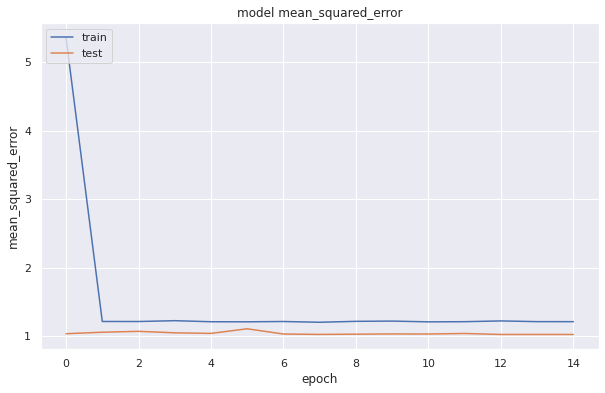

RMSE:  1.1104092679424369


In [38]:
# fix random seed for reproducibility
np.random.seed(18)

# create the model
embedding_vector_length = 32

# use sequential model
model_s = Sequential()

# add embedding layer
model_s.add(Embedding(top_words, embedding_vector_length, input_length=max_number_of_words))

# add LSTM neurons
model_s.add(LSTM(100))

# add dense layer
model_s.add(Dense(1, activation='relu'))

# compile
model_s.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
print(model_s.summary())

# fit
# model_s.fit(x_train, y_train, epochs=3, batch_size=32)
history = model_s.fit(x_train, y_train, validation_split=0.2, epochs=15, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# # Final evaluation of the model
scores = model_s.evaluate(x_test, y_test, verbose=0)
print("RMSE: ",(np.sqrt(scores[1])))


Hyperparameter Tuning
- Below are an example of tuning using Gridsearch
- Tuning using Keras Tuner will be included in next version

In [39]:
def create_model(optimizer='adam',activation='relu'):
    # create model
    model_s = Sequential()  
    
    model_s.add(Embedding(2000, 32, input_length=max_number_of_words))

    # add LSTM neurons
    model_s.add(LSTM(100))

    # add dense layer
    model_s.add(Dense(1))

    # compile
    model_s.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
#     print(model_s.summary())
    return model_s

In [40]:
model = KerasRegressor(build_fn=create_model,epochs=2, verbose=0)
# define the grid search parameters
batch_size = [32, 64]
epochs = [1,3,5]
optimizer = ['RMSprop','adam']
activation = ['relu', 'tanh']

param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, activation=activation)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -1.169794 using {'activation': 'relu', 'batch_size': 32, 'epochs': 1, 'optimizer': 'adam'}


In [41]:
# Observe performance after Gridsearch

# fix random seed for reproducibility
np.random.seed(18)

# create the model
embedding_vector_length = 32

# use sequential model
model_s = Sequential()

# add embedding layer
model_s.add(Embedding(top_words, embedding_vector_length, input_length=max_number_of_words))

# add LSTM neurons
model_s.add(LSTM(100))

# add dense layer
model_s.add(Dense(1, activation=grid_result.best_params_['activation']))

# compile
model_s.compile(loss='mean_squared_error', optimizer=grid_result.best_params_['optimizer'], metrics=['mean_squared_error'])
print(model_s.summary())

# fit
# model_s.fit(x_train, y_train, epochs=3, batch_size=32)
model_s.fit(x_train, y_train, validation_split=0.2, epochs=grid_result.best_params_['epochs'], batch_size=grid_result.best_params_['batch_size'], verbose=0)

# # Final evaluation of the model
scores = model_s.evaluate(x_test, y_test, verbose=0)
print("RMSE: ",(np.sqrt(scores[1])))


Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_122 (Embedding)    (None, 1668, 32)          64000     
_________________________________________________________________
lstm_122 (LSTM)              (None, 100)               53200     
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 101       
Total params: 117,301
Trainable params: 117,301
Non-trainable params: 0
_________________________________________________________________
None
RMSE:  1.1208219298358142
